# LSTM for Pump Downtime Forecasting
### Author: Christian Grech

* Aim: using Lagged features and LSTM model to forecast pump downtime in advance.
* Techniques used: 
 - Feature importance,
 - LSTM, 
 - Early Stopping, 
 - Train/Valid/Test split, 
 - Feature lagging, 
 - Normalization

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score

import datetime
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pump-sensor-data/sensor.csv


## Data Cleaning and Exploration

Let's check for null values in our columns.

<AxesSubplot:>

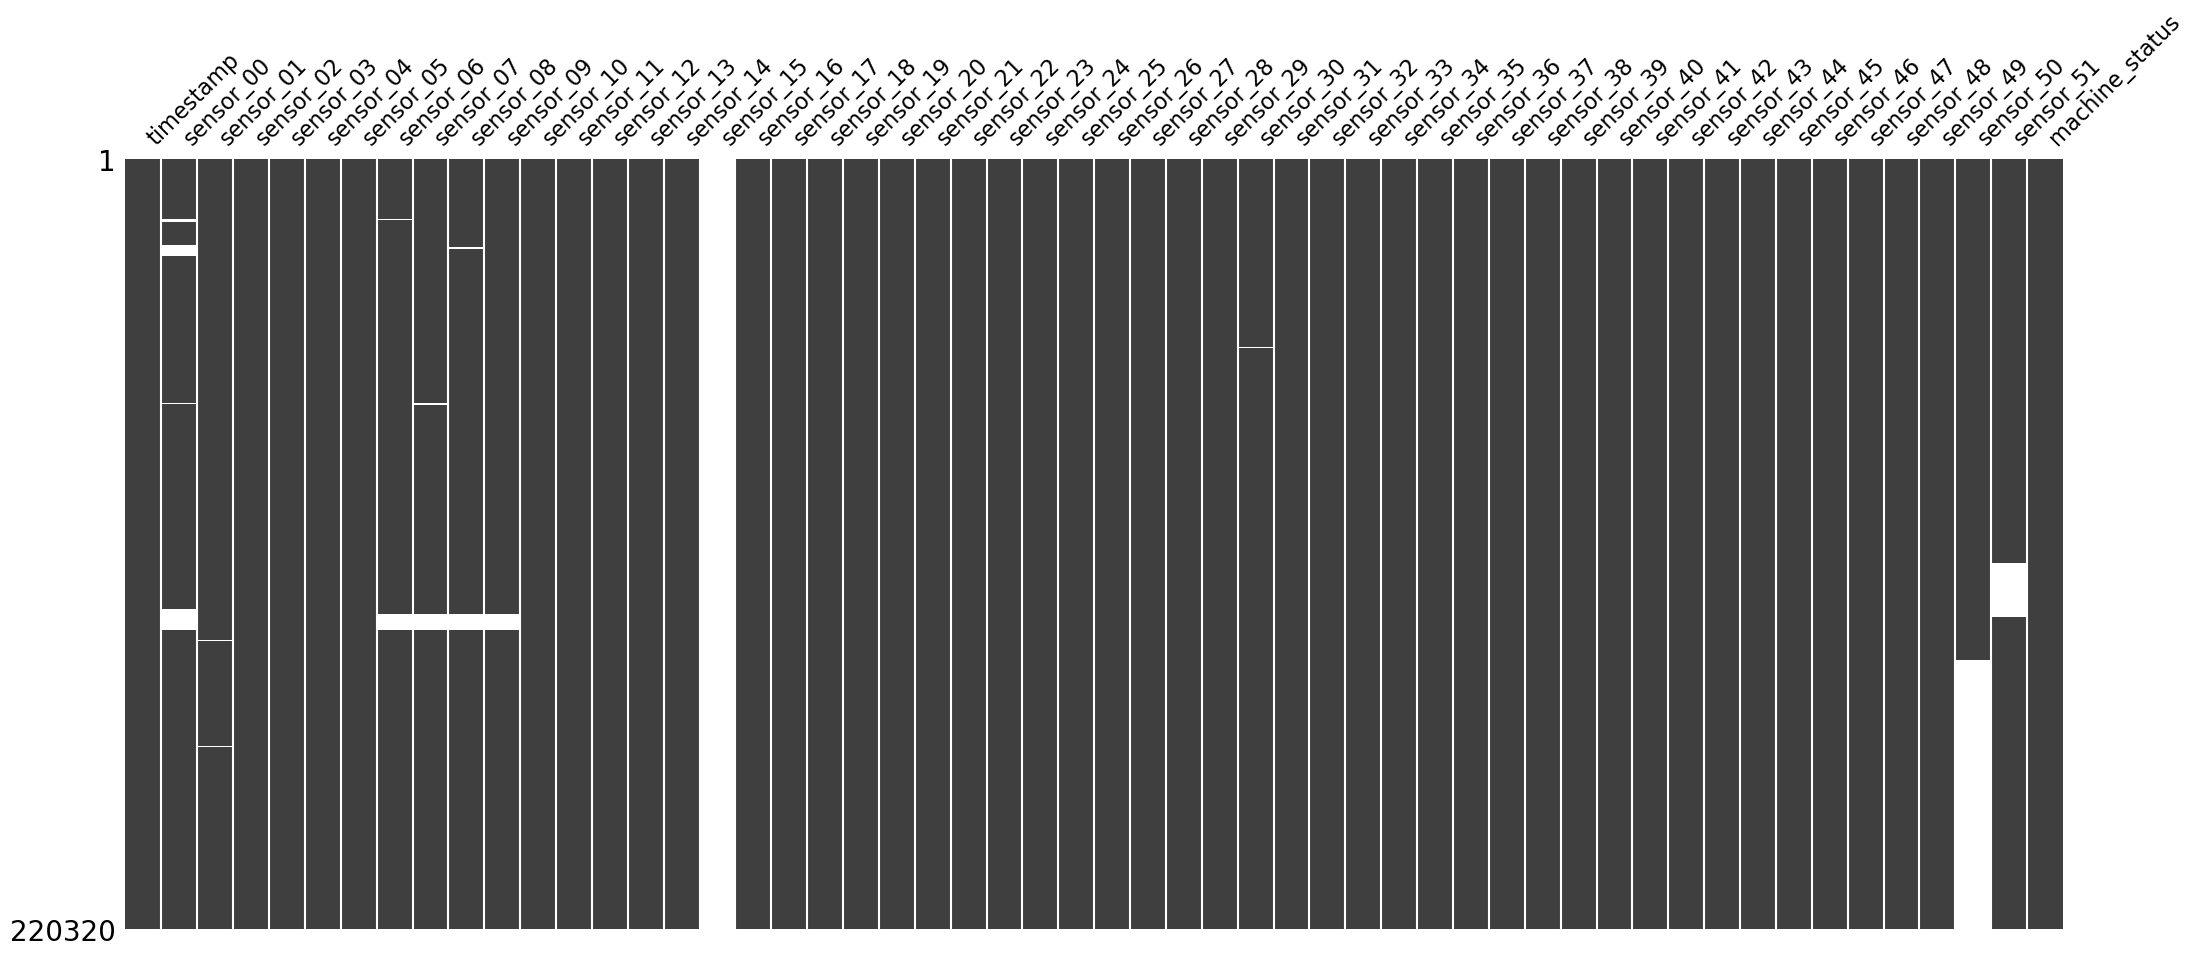

In [2]:
df = pd.read_csv(os.path.join(dirname, filename), index_col=0)
msno.matrix(df, labels=True, sparkline=False)

In [3]:
df['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [4]:
# Sensor 37 seems to consist of noise only so it is dropped
df.drop(['sensor_50','sensor_15', 'sensor_37'] , axis = 1 , inplace = True)
df.fillna(method = 'ffill' , inplace = True)

df['date'] = pd.to_datetime(df['timestamp'])
del df['timestamp']
df = df.set_index('date')

Let's explore any cyclic patterns which could help in forecasting:

In [5]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['minute'] = df.index.minute
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

Visualize one sensor to check how downtime happens. It looks like Downtime is represented by a Broken label followed by a number of Recovering labels.

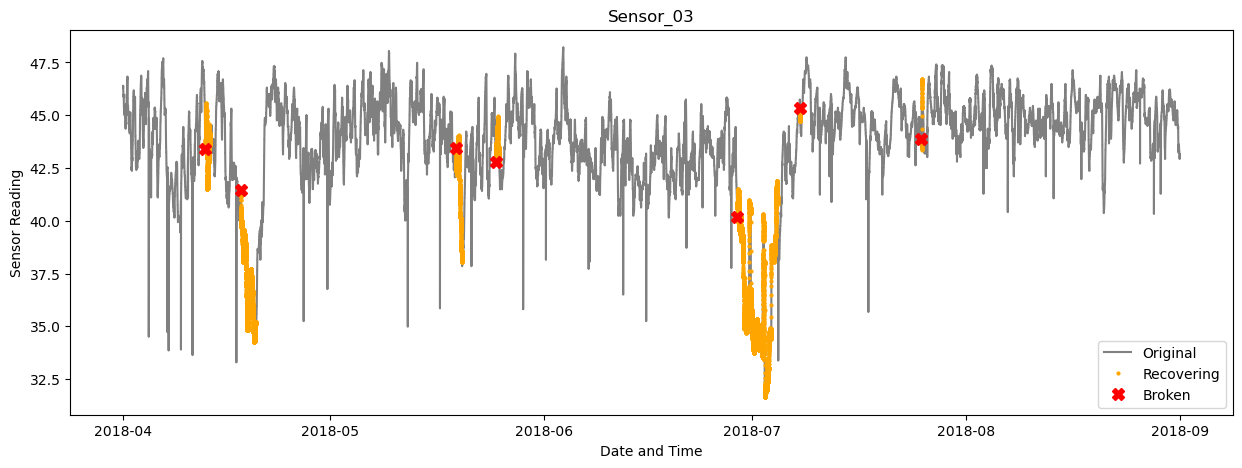

In [6]:
broken = df[df['machine_status']=='BROKEN']
recovering = df[df['machine_status']=='RECOVERING']
sensor = 'sensor_03'
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(df[sensor], color='grey',label='Original')
plt.plot(recovering[sensor], linestyle='none', marker='o', color='orange', markersize=2, label='Recovering')
plt.plot(broken[sensor], linestyle='none', marker='X', color='red', markersize=8, label='Broken')
#ax.axvline(test.index.min(), color='black', ls='--')
#ax.set_facecolor('xkcd:white')
plt.xlabel('Date and Time')
plt.ylabel('Sensor Reading')
plt.title('Sensor_03')
plt.legend(loc='best')
plt.show()

Looking deeper on when the downtime starts, we can see no particular day of the week or day of month but it looks like 6/7 faults happen between 9pm and 5am. So let's create a new column: partofday with Morning (0, 5am-1pm), Afternoon (1, 1pm-9pm), Night (2, 9pm-5am). 

In [7]:
def partofday (row):
    if  5 <= row['hour'] <= 12:
        return 0
    elif 13 <= row['hour'] <= 20:
        return 1
    elif row['hour'] <= 4 or row['hour'] >= 21:
        return 2
    else:
        return 'Other'
df['partofday'] = df.apply (lambda row: partofday(row), axis=1)
df[df['machine_status']=='BROKEN']

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,minute,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,partofday
date,,,,,,,,,,,,,,,,,,,,,
2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,16.869210,15.082470,...,55,21,3,2,4,2018,102,12,15,2
2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,14.185470,13.867190,...,30,0,2,2,4,2018,108,18,16,2
2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,15.147570,14.793110,...,18,3,5,2,5,2018,139,19,20,2
2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,15.943290,15.596060,...,30,0,4,2,5,2018,145,25,21,2
2018-06-28 22:00:00,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.335360,15.270540,15.183740,15.118630,...,0,22,3,2,6,2018,179,28,26,2
2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,0.036169,0.007234,...,11,0,6,3,7,2018,189,8,27,2
2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,15.697340,15.053530,...,0,14,2,3,7,2018,206,25,30,1


In [8]:
def normalization(sig):
    normalized_features=MinMaxScaler().fit_transform(sig) 
    return normalized_features

## LSTM model

This function creates lagged/forecasted features

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(),list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names +=[('sensor_%d(t-%d)' %(j+1, i)) for j in range (n_vars)]
    #forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names +=[('sensor_%d(t)' %(j+1)) for j in range (n_vars)]
        else:
            names +=[('sensor_%d(t+%d)' %(j+1, i)) for j in range (n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns=names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Define the LSTM model

In [10]:
def model_(in_shape):
    inputs= tf.keras.Input(shape=(in_shape[1],in_shape[2]))
    x=LSTM(8, input_shape=(in_shape[1],in_shape[2]),return_sequences=True)(inputs)
    x=LSTM(8)(x)
    #x=Dropout(0.4)(x)
    #out_signal=Dense(1, name='out')(x)
    out_class=Dense(1,activation='sigmoid', name='out')(x)
    
    model=tf.keras.Model(inputs=inputs, outputs=out_class)
    
    model.compile(loss={'out' :'binary_crossentropy'},
                         optimizer='adam',
                         metrics={'out':'acc'})
    #mean_squared_error
    print(model.summary())
    return model  

In [11]:
n_splits = 2
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
#top_features = ['sensor_04','sensor_06','sensor_07','sensor_08', 'sensor_09']#'sensor_40','sensor_04']#'sensor_00'
feat = df.columns.drop('machine_status').tolist()
features = feat + ['machine_status']

target_cols = ['machine_status']
features_cols = features

X = df[features]
y = df[target_cols]
Lag=10 # How many steps to look into the future
data_shift=series_to_supervised(X, n_in=Lag, n_out=1)
remove_list_1 =['sensor_'+str(n)+'(t)' for n in range(1,len(X.columns)+1)] #now remove all non shifted elements again. so we retreive elements and shifted target
#remove_list_2 =['sensor_'+str(len(X.columns))+'(t-'+ str(i)+')' for i in range(1,Lag+1)] #now remove all non shifted elements again. so we retreive elements and shifted target
remove_list_2 =['sensor_'+str(n)+'(t-'+ str(i)+')' for n in range(1,len(X.columns)+1) for i in range(1,Lag)]
data_y=data_shift.iloc[:,-1] #Get the target data out before removing unwanted data
data_y=data_y.replace(['NORMAL', 'BROKEN', 'RECOVERING'],[1, 0, 0]) #Get the target data out before removing unwanted data
#data_y=data_y.shift(Lag).dropna()
data_x=data_shift.drop(remove_list_1+remove_list_2, axis=1) #remove sensors(t)
data_x.drop(data_x.columns[len(data_x.columns)-1], axis=1, inplace=True)

Split the dataset in three sets and normalize

In [12]:
X_train = data_x.iloc[0:110000, :]
X_test = data_x.iloc[110000:140000 ,:]
X_val= data_x.iloc[140000:: ,:]

y_train = data_y.iloc[0:110000]
y_test= data_y.iloc[110000:140000]
y_val = data_y.iloc[140000::]

# normalize data 
normalize = MinMaxScaler()
X_train = normalize.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = data_x.columns

X_test = normalize.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = data_x.columns

X_val = normalize.transform(X_val)
X_val = pd.DataFrame(X_val)
X_val.columns = data_x.columns

train_df = X_train.set_index(data_x.iloc[0:110000, :].index)
test_df = X_test.set_index(data_x.iloc[110000:140000 ,:].index)
val_df = X_val.set_index(data_x.iloc[140000:: ,:].index)

## Feature importance

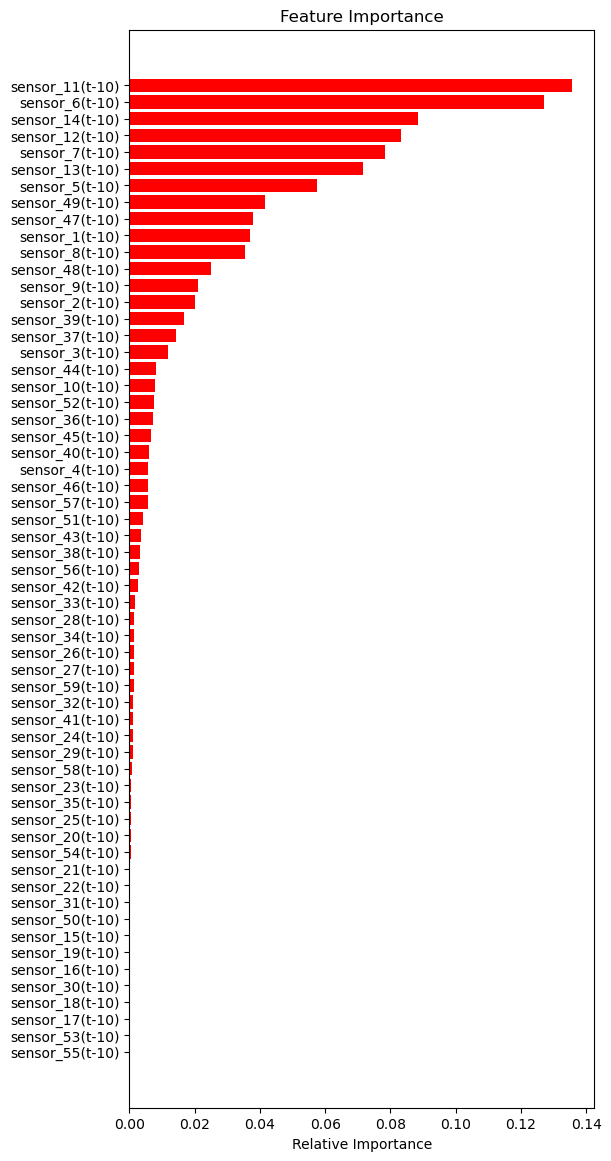

In [13]:
model = RandomForestClassifier(max_depth=40, random_state=0, n_estimators=150)
model.fit(X_train, y_train)  
importances = model.feature_importances_
indices = np.argsort(importances)

features = X_train.columns

fig = plt.figure(figsize=(6,14),facecolor="w")
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

top_features = [features[i] for i in indices][-8:]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 8)              544       
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 out (Dense)                 (None, 1)                 9         
                                                                 
Total params: 1,097
Trainable params: 1,097
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
860/860 [==============================] - 16s 9ms/step - loss: 0.1963 - acc: 0.9413 - val_loss: 0.0160 - val_acc: 0.9985
Epoch 2/50
860/860 [==============================] -

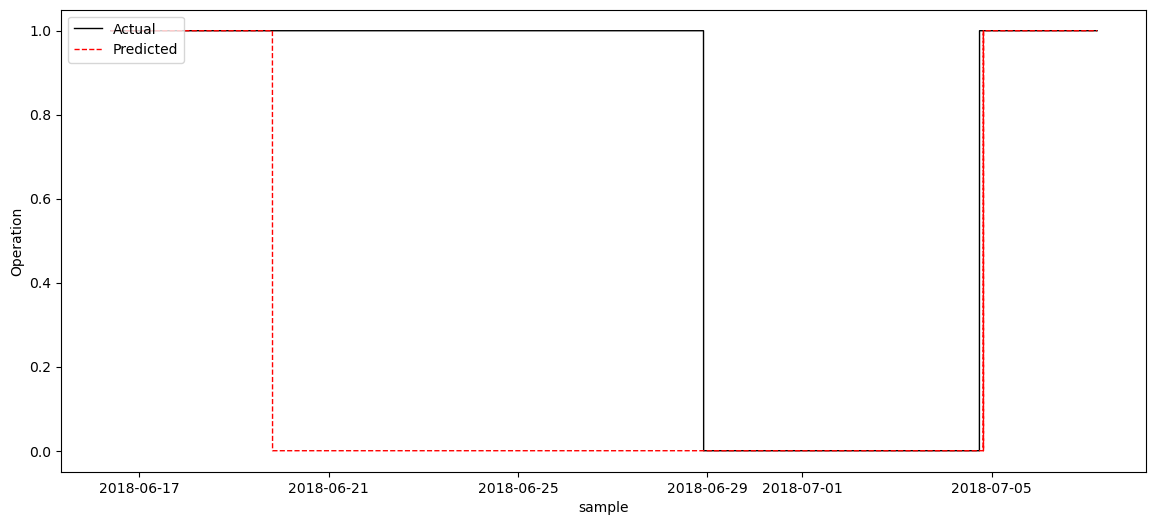

In [14]:
train_X=np.asarray(train_df[top_features]).astype('float32')
train_Y=y_train.astype('float32')
    
val_X=np.asarray(val_df[top_features]).astype('float32')
val_Y=y_val.astype('float32')
    
test_X=np.asarray(test_df[top_features]).astype('float32')
test_Y=y_test.astype('float32')
    #weight_train = compute_sample_weight('balanced', train_Y)
    #weight_test = compute_sample_weight('balanced', test_Y)
    
    
# reshape for input 
timesteps=1
samples_T=int(np.floor(train_X.shape[0]/timesteps))
samples_V=int(np.floor(val_X.shape[0]/timesteps))
samples_Te=int(np.floor(test_X.shape[0]/timesteps))

train_X=train_X.reshape((samples_T,timesteps,train_X.shape[1]))   #samples, timesteps, sensors   
val_X=val_X.reshape((samples_V,timesteps,val_X.shape[1]))       
test_X=test_X.reshape((samples_Te,timesteps,test_X.shape[1]))  
    
model=model_(train_X.shape)
history = model.fit(train_X, train_Y, epochs=50, batch_size=128, validation_data=(val_X, val_Y), shuffle=False, callbacks=[callback])
    
yclass_ = model.predict(test_X)    
yclass=np.transpose(yclass_)[0]  # transformation to get (n,)
# Applying transformation to get binary values predictions with 0.5 as thresold
yclass = list(map(lambda x: 0 if x<0.5 else 1, yclass))
    
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
plt.plot(test_Y, color='black', label='Actual', linestyle='solid', linewidth=1)
plt.plot(data_y.index[110000:140000], yclass, color='red', label='Prediction', linestyle='dashed', linewidth=1 )
plt.ylabel('Operation')
plt.xlabel('sample')
plt.legend(['Actual', 'Predicted'], loc='upper left')
    #if ii == 0:
    #    plt.xlim([datetime.datetime(2018, 5, 24, 22, 0), datetime.datetime(2018, 5, 27, 1)])
    #else:
    #    plt.xlim([datetime.datetime(2018, 7, 25, 12, 0), datetime.datetime(2018, 7, 25, 21)])
plt.show()
    #break
    
    

In [15]:
model.save('./model/LSTM_128bs_'+ str(Lag))


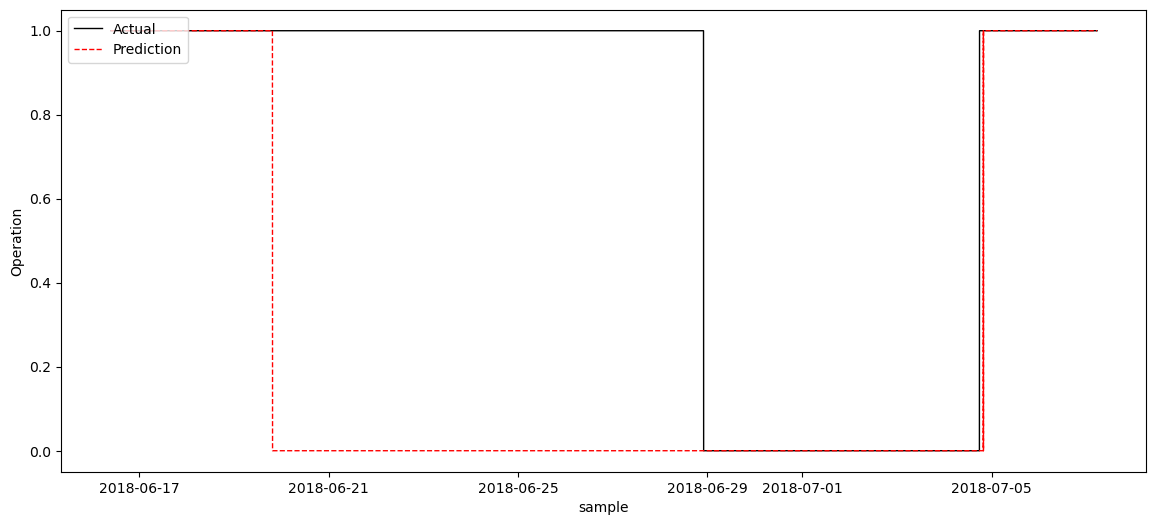

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
#plt.plot(data_x.index[test_index-Future], data_x['sensor_1(t-10)'][test_index], color='black', label='Shifted', linestyle='solid', linewidth=1)
#plt.plot(df.index[test_index], df['sensor_48'][test_index], color='green', label='Original', linestyle='solid', linewidth=1)

plt.plot(test_Y, color='black', label='Actual', linestyle='solid', linewidth=1)
plt.plot(data_y.index[110000:140000],yclass, color='red', label='Prediction', linestyle='dashed', linewidth=1 )
plt.ylabel('Operation')
plt.xlabel('sample')
plt.legend(loc='upper left')
#plt.xlim([4340, 4400])
#plt.xlim([datetime.datetime(2018, 7, 7, 22, 0), datetime.datetime(2018, 7, 8, 1)])

We can see that we are able to predict downtime in advance

Plot the loss/accuracy curves for training/validation datasets

In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['val_acc'], name="val acc"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=history.history['acc'], name="accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of LSTM Model"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.show()

## Conclusion

- We have performed a Proof of Concept to predict downtime or normal operation using an LSTM model.
- As the dataset is unbalanced with a majority of normal operation target data, weights for this class are given lower influence.
- With this method we can predict the major downtime periods based on the most important sensors.
- There seems to be no cyclic relationship between downtime and time of day or day of the week. This makes forecasting the sensor signals quite hard to get right.
- To use model, eventually it is recommended to train the model with the complete dataset.
